# Setting up Colab environment

In [ ]:
import os
username = 'SkoltechAI'
repo = 'Recommender-Systems-Intro-Sber-2022'

# remove local directory if it already exists
if os.path.isdir(repo):
    !rm -rf {repo}

!git clone https://github.com/{username}/{repo}.git

In [ ]:
!pip install --no-cache-dir --upgrade git+https://github.com/evfro/polara.git@develop#egg=polara

In [25]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

import torch
import torch.nn as nn

from polara import get_movielens_data
from polara.preprocessing.dataframes import reindex, leave_one_out

# navigating to cloned repo directory in Colab
%cd {repo}
from dataprep import transform_indices
from evaluation import topn_recommendations, model_evaluate, downvote_seen_items
%cd -

# Preparing data

In [2]:
mldata = get_movielens_data(include_time=True)

In [3]:
test_timepoint = mldata['timestamp'].quantile(
    q=0.95, interpolation='nearest'
)

In [4]:
test_data_ = mldata.query('timestamp >= @test_timepoint')

In [5]:
test_data_.nunique()

userid         813
movieid       3249
rating           5
timestamp    33729
dtype: int64

In [6]:
train_data_ = mldata.query(
    'userid not in @test_data_.userid.unique() and timestamp < @test_timepoint'
)

In [7]:
training, data_index = transform_indices(train_data_.copy(), 'userid', 'movieid')

In [8]:
test_data = reindex(test_data_, data_index['items'])

Filtered 64 invalid observations.


In [9]:
test_data.nunique()

userid         813
movieid       3220
rating           5
timestamp    33678
dtype: int64

We sample the last item for each test user.  
As all these users are excluded from the training, and training is additionally filtered by timestamp,
there will be no "recommendation from future" issue - our model is unaware of future correlations.


In [10]:
testset_, holdout_ = leave_one_out(
    test_data, target='timestamp', sample_top=True, random_state=0
)
testset_valid_, holdout_valid_ = leave_one_out(
    testset_, target='timestamp', sample_top=True, random_state=0
)

Let's focus on validation part.

In [11]:
userid = data_index['users'].name
test_users = pd.Index(
    np.intersect1d(
        testset_valid_[userid].unique(),
        holdout_valid_[userid].unique()
    )
)
testset_valid = (
    testset_valid_
    # reindex warm-start users for convenience
    .assign(**{userid: lambda x: test_users.get_indexer(x[userid])})
    .query(f'{userid} >= 0')
    .sort_values('userid')
)
holdout_valid = (
    holdout_valid_
    # reindex warm-start users for convenience
    .assign(**{userid: lambda x: test_users.get_indexer(x[userid])})
    .query(f'{userid} >= 0')
    .sort_values('userid')
)

In [12]:
testset_valid.nunique()

userid         750
movieid       3202
rating           5
timestamp    32400
dtype: int64

In [13]:
holdout_valid.shape

(750, 4)

In [14]:
assert holdout_valid.set_index('userid')['timestamp'].ge(
    testset_valid
    .groupby('userid')
    ['timestamp'].max()
).all()

In [65]:
train_sessions = (
    training
    .sort_values(['userid', 'timestamp'])
    .groupby('userid')
    ['movieid']
    .apply(list)
)

In [66]:
print(train_sessions[0])

[2925, 1158, 1547, 939, 2111, 1629, 3129, 2559, 1097, 1084, 677, 252, 840, 587, 2448, 1750, 1817, 2846, 859, 952, 1751, 1807, 143, 945, 1007, 835, 1175, 2552, 2517, 1134, 631, 2668, 514, 2855, 2546, 2092, 946, 1087, 574, 2169, 1397, 510, 575, 2443, 696, 568, 0, 2126, 2067, 726, 1414, 1697, 47]


In [53]:
valid_sessions = (
    testset_valid
    .sort_values(['userid', 'timestamp'])
    .groupby('userid')
    ['movieid']
    .apply(list)
)

In [57]:
data_description = dict(
    users = data_index['users'].name,
    items = data_index['items'].name,
    order = 'timestamp',
    n_users = len(data_index['users']),
    n_items = len(data_index['items']),
)
data_description

{'users': 'userid',
 'items': 'movieid',
 'order': 'timestamp',
 'n_users': 5227,
 'n_items': 3652}

# Batch Sampler

In [58]:
def sequential_batch_sampler(user_train, usernum, itemnum, batch_size, maxlen, seed, pad_token=None):
    if pad_token is None:
        pad_token = itemnum
    
    def sample(random_state):
        user = random_state.randint(usernum)
        while len(user_train.get(user, [])) <= 1:
            user = random_state.randint(usernum)
        user_items = user_train[user]
        seq = np.full([maxlen], pad_token, dtype=np.int32)
        pos = np.full([maxlen], pad_token, dtype=np.int32)
        neg = np.full([maxlen], pad_token, dtype=np.int32)
        nxt = user_items[-1]
        idx = maxlen - 1
        ts = set(user_items)
        for i in reversed(user_items[:-1]):
            seq[idx] = i
            pos[idx] = nxt
            neg[idx] = random_neq(0, itemnum, ts, random_state)
            nxt = i
            idx -= 1
            if idx == -1:
                break
        return (user, seq, pos, neg)
    
    random_state = np.random.RandomState(seed)
    while True:
        yield zip(*(sample(random_state) for _ in range(batch_size)))


def random_neq(l, r, s, random_state):
    t = random_state.randint(l, r)
    while t in s:
        t = random_state.randint(l, r)
    return t

# SASRec model

The code is adapted from https://github.com/pmixer/SASRec.pytorch

In [59]:
class PointWiseFeedForward(nn.Module):
    def __init__(self, hidden_units, dropout_rate):

        super(PointWiseFeedForward, self).__init__()

        self.conv1 = nn.Conv1d(hidden_units, hidden_units, kernel_size=1)
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(hidden_units, hidden_units, kernel_size=1)
        self.dropout2 = nn.Dropout(p=dropout_rate)

    def forward(self, inputs):
        outputs = self.dropout2(self.conv2(self.relu(self.dropout1(self.conv1(inputs.transpose(-1, -2))))))
        outputs = outputs.transpose(-1, -2) # as Conv1D requires (N, C, Length)
        outputs += inputs
        return outputs


class SASRec(nn.Module):
    def __init__(self, user_num, item_num, config, maxlen, device):
        super(SASRec, self).__init__()

        self.user_num = user_num
        self.item_num = item_num
        self.dev = device
        self.pad_token = item_num

        self.item_emb = nn.Embedding(self.item_num+1, config['hidden_units'], padding_idx=self.pad_token)
        self.pos_emb = nn.Embedding(maxlen, config['hidden_units']) # TO IMPROVE
        self.emb_dropout = nn.Dropout(p=config['dropout_rate'])

        self.attention_layernorms = nn.ModuleList() # to be Q for self-attention
        self.attention_layers = nn.ModuleList()
        self.forward_layernorms = nn.ModuleList()
        self.forward_layers = nn.ModuleList()
        self.last_layernorm = nn.LayerNorm(config['hidden_units'], eps=1e-8)

        for _ in range(config['num_blocks']):
            new_attn_layernorm = nn.LayerNorm(config['hidden_units'], eps=1e-8)
            self.attention_layernorms.append(new_attn_layernorm)
            new_attn_layer =  nn.MultiheadAttention(
                config['hidden_units'],config['num_heads'],config['dropout_rate']
            )
            self.attention_layers.append(new_attn_layer)

            new_fwd_layernorm = nn.LayerNorm(config['hidden_units'], eps=1e-8)
            self.forward_layernorms.append(new_fwd_layernorm)

            new_fwd_layer = PointWiseFeedForward(config['hidden_units'], config['dropout_rate'])
            self.forward_layers.append(new_fwd_layer)
        
        self.initialize()


    def initialize(self):
        for name, param in self.named_parameters():
            try:
                torch.nn.init.xavier_uniform_(param.data)
            except:
                pass # just ignore those failed init layers


    def log2feats(self, log_seqs):
        seqs = self.item_emb(torch.LongTensor(log_seqs).to(self.dev))
        seqs *= self.item_emb.embedding_dim ** 0.5
        positions = np.tile(np.arange(log_seqs.shape[1]), [log_seqs.shape[0], 1])
        seqs += self.pos_emb(torch.LongTensor(positions).to(self.dev))
        seqs = self.emb_dropout(seqs)

        timeline_mask = torch.BoolTensor(log_seqs == self.pad_token).to(self.dev)
        seqs *= ~timeline_mask.unsqueeze(-1) # broadcast in last dim

        tl = seqs.shape[1] # time dim len for enforce causality
        attention_mask = ~torch.tril(torch.ones((tl, tl), dtype=torch.bool, device=self.dev))

        for i in range(len(self.attention_layers)):
            seqs = torch.transpose(seqs, 0, 1)
            Q = self.attention_layernorms[i](seqs)
            mha_outputs, _ = self.attention_layers[i](
                Q, seqs, seqs, attn_mask=attention_mask
            )
        
            seqs = Q + mha_outputs
            seqs = torch.transpose(seqs, 0, 1)

            seqs = self.forward_layernorms[i](seqs)
            seqs = self.forward_layers[i](seqs)
            seqs *=  ~timeline_mask.unsqueeze(-1)

        log_feats = self.last_layernorm(seqs) # (U, T, C) -> (U, -1, C)

        return log_feats

    def forward(self, user_ids, log_seqs, pos_seqs, neg_seqs): # for training        
        log_feats = self.log2feats(log_seqs) # user_ids hasn't been used yet

        pos_embs = self.item_emb(torch.LongTensor(pos_seqs).to(self.dev))
        neg_embs = self.item_emb(torch.LongTensor(neg_seqs).to(self.dev))

        pos_logits = (log_feats * pos_embs).sum(dim=-1)
        neg_logits = (log_feats * neg_embs).sum(dim=-1)

        return pos_logits, neg_logits # pos_pred, neg_pred

    def predict(self, user_ids, log_seqs, item_indices): # for inference
        log_feats = self.log2feats(log_seqs) # user_ids hasn't been used yet

        final_feat = log_feats[:, -1, :] # only use last QKV classifier, a waste

        item_embs = self.item_emb(torch.LongTensor(item_indices).to(self.dev)) # (U, I, C)

        logits = item_embs.matmul(final_feat.unsqueeze(-1)).squeeze(-1)

        return logits # preds # (U, I)


    def score(self, seq):
        maxlen = self.pos_emb.num_embeddings
        log_seqs = np.full(maxlen, self.pad_token, dtype=np.int32)
        log_seqs[-len(seq):] = seq[-maxlen:]

        log_feats = self.log2feats(np.array(log_seqs, ndmin=2, copy=False))
        final_feat = log_feats[:, -1, :] # only use last QKV classifier, a waste

        item_embs = self.item_emb.weight # (U, I, C)
        logits = item_embs.matmul(final_feat.unsqueeze(-1)).squeeze(-1)
        return logits # preds # (U, I)

## Training 

In [60]:
def prepare_sasrec_model(config, data, data_description):
    # user_train, n_users, n_items, config, maxlen, device, seed=None):
    n_users = data_description['n_users']
    n_items = data_description['n_items']
    maxlen = config['maxlen']
    device = None
    if torch.cuda.is_available():
        device = 'cuda:0'
    model = SASRec(n_users, n_items, config, maxlen, device)
    sampler = sequential_batch_sampler(
        data, n_users, n_items,
        batch_size=config['batch_size'],
        maxlen=maxlen,
        seed=config['sampler_seed'],
        pad_token=model.pad_token
    )
    criterion = torch.nn.BCEWithLogitsLoss().cuda()
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr = config['learning_rate'],
        betas = (0.9, 0.98)
    )
    return model, sampler, criterion, optimizer    

In [61]:
def train_sasrec_epoch(model, num_batch, l2_emb, sampler, optimizer, criterion):
    model.train()
    device = model.dev
    pad_token = model.pad_token
    losses = []
    for _ in range(num_batch):
        u, seq, pos, neg = [np.array(x) for x in next(sampler)]
        pos_logits, neg_logits = model(u, seq, pos, neg)
        pos_labels = torch.ones(pos_logits.shape, device=device)
        neg_labels = torch.zeros(neg_logits.shape, device=device)
        optimizer.zero_grad()
        indices = np.where(pos != pad_token)
        loss = criterion(pos_logits[indices], pos_labels[indices])
        loss += criterion(neg_logits[indices], neg_labels[indices])
        if l2_emb != 0:
            for param in model.item_emb.parameters():
                loss += l2_emb * torch.norm(param)**2
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

In [62]:
def build_sasrec_model(config, data, data_description):
    '''Simple MF training routine without early stopping'''
    model, sampler, criterion, optimizer = prepare_sasrec_model(config, data, data_description)
    model = model.cuda()
    num_batch = len(data) // config['batch_size'] 
    losses = {}
    for epoch in tqdm(range(config['num_epochs'])):
        losses[epoch] = train_sasrec_epoch(model, num_batch, config['l2_emb'], sampler, optimizer, criterion)
    return model, losses

In [63]:
config = dict(
    num_epochs = 20,
    maxlen = 200,
    hidden_units = 64,
    dropout_rate = 0.2,
    num_blocks = 1,
    num_heads = 1,
    batch_size = 64,
    sampler_seed = 99,
    learning_rate = 1e-3,
    l2_emb = 0,
)

In [67]:
model, losses = build_sasrec_model(config, train_sessions, data_description)

100%|██████████| 20/20 [02:19<00:00,  6.97s/it]


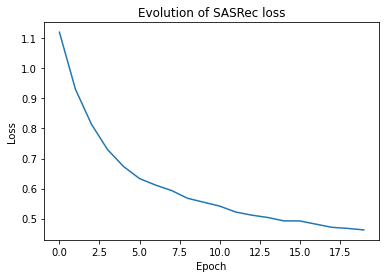

In [68]:
pd.Series(losses).apply(np.mean).plot(title='Evolution of SASRec loss', xlabel='Epoch', ylabel='Loss');

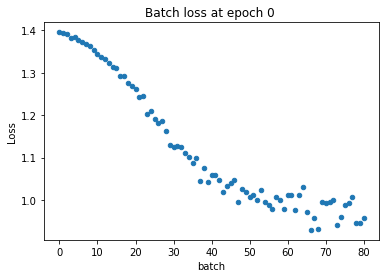

In [69]:
epoch = 0
epoch_loss_series = pd.Series(losses[epoch], name='Loss').rename_axis('batch')
ax = epoch_loss_series.reset_index().plot.scatter(
    x='batch', y='Loss', title=f'Batch loss at epoch {epoch} '
)

# Evaluation

In [70]:
def sasrec_model_scoring(params, data, data_description):
    model = params
    model.eval()
    # perform scoring on a user-batch level
    scores = []
    for user, seq in data.items():
        with torch.no_grad():
            predictions = model.score(seq)
        scores.append(predictions.detach().cpu().numpy())
    return np.concatenate(scores, axis=0)

In [71]:
sasrec_scores = sasrec_model_scoring(model, valid_sessions, data_description)

In [72]:
downvote_seen_items(sasrec_scores, testset_valid, data_description)

In [73]:
sasrec_recs = topn_recommendations(sasrec_scores, topn=10)
model_evaluate(sasrec_recs, holdout_valid, data_description)

(0.07066666666666667, 0.03162857142857142, 0.2864184008762322)